In [1]:
import sys
import os 
sys.path.insert(0, os.path.abspath('..'))

from functools import reduce 

from pysis.isis import spiceinit, footprintinit, jigsaw, pointreg, cam2map
from pysis.exceptions import ProcessError
import pvl 
import matplotlib.pyplot as plt

import autocnet
from autocnet import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher import suppression_funcs


from functools import partial

import subprocess
from subprocess import Popen, PIPE

import gdal
import plio 
from plio.io.io_gdal import GeoDataset


import themis
from themis import config
from themis.examples import get_path


%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 50, 100

In [3]:
!module load davinci
!source /usgs/cpkgs/isis3/isis3mgr_scripts/initIsisCmake.sh isis3

 ISIS3 Setup In: /usgs/pkgs/isis3.5.2/isis - Successful



In [4]:
mapfile = pvl.loads("""
Group = Mapping
  ProjectionName = Equirectangular
  CenterLongitude = 0.0
  TargetName = Mars
  LatitudeType = Planetocentric
  LongitudeDirection = PositiveEast
  LongitudeDomain = 180
End_Group
""")

In [64]:
def run_davinci(script, infile=None, outfile=None, bin_dir=config.davinci_bin, args=[]):
    '''
    '''
    command = ['davinci', '-f', os.path.join(bin_dir, script), 'from={}'.format(infile), 'to={}'.format(outfile)]

    # add additional positional args
    if args:
        command.extend(args)

    print(' '.join(command))
    p = Popen(command, stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate(b"input data that is passed to subprocess' stdin")
    rc = p.returncode

    if rc != 0:
        raise Exception('Davinci returned non-zero error code {} : {}'.format(rc, err.decode('utf-8')))
    return output.decode('utf-8'), err.decode('utf-8')

def init(thm_id, outfile):
    '''
    Downloads Themis file by ID and runs it through spice init and
    footprint init.
    '''

    # Download themis file
    out, err = run_davinci('thm_pre_process.dv', infile=thm_id, outfile=outfile)
    
    # Run spiceinit and footprintint
    try:
        spiceinit(from_=outfile)
    except ProcessError as e:
        print('Spice Init Error')
        print('file: {}'.format(outfile))
        print("STDOUT:", e.stdout.decode('utf-8'))
        print("STDERR:", e.stderr.decode('utf-8'))
    try:
        footprintinit(from_=outfile)
    except ProcessError as e:
        print('Footprint Init Error')
        print('file: {}'.format(outfile))
        print("STDOUT:", e.stdout.decode('utf-8'))
        print("STDERR:", e.stderr.decode('utf-8'))

def thm_crop(infile, outfile, minlat, maxlat):
    run_davinci('thm_crop_lat.dv', infile, outfile, args=['minlat={}'.format(str(minlat)), 'maxlat={}'.format(maxlat)])


def match(img1, img2, extraction_kwargs={}, fmatrix_params={}, suppr_params={}, pointreg_params={}, bundle_params={}):
    '''
    Matches a list of files.

    Parameters
    ----------
    filelist : list
               list of files to match, they must of had spiceinit and footprint init run on them

    fmatrix_params : dict
                     Dictionary of params for computing the fundamental matrix

    suppr_params : dict
                   Dictionary of params for spatially suppressing control points

    pointreg_params : dict
                      parameters for the isis3 application point for subpixel registration

    bundle_params : dict
                    parameters for the isis3 application jigsaw for bundle adjustment

    See Also
    --------
    extractor params: https://github.com/USGS-Astrogeology/autocnet/blob/dev/autocnet/matcher/cpu_extractor.py
    ration check params: https://github.com/USGS-Astrogeology/autocnet/blob/dev/autocnet/matcher/cpu_outlier_detector.py
    spatial suppression params: https://github.com/USGS-Astrogeology/autocnet/blob/dev/autocnet/matcher/cpu_outlier_detector.py
    jigsaw: https://isis.astrogeology.usgs.gov/Application/presentation/Tabbed/jigsaw/jigsaw.html
    pointreg: https://isis.astrogeology.usgs.gov/Application/presentation/Tabbed/pointreg/pointreg.html
    '''
    filelist = [img1_path, img2_path]
    cg = CandidateGraph.from_filelist(filelist)
    # The range of DN values over the data is small, so the threshold for differentiating interesting features must be small.
    cg.extract_features(extractor_parameters={'contrastThreshold':0.000001})
    cg.match()

    e = cg[0][1]['data'] 
    e.symmetry_check()
    e.ratio_check(clean_keys=['symmetry'])

    cg.compute_fundamental_matrices(clean_keys=['symmetry', 'ratio'], reproj_threshold=1, mle_reproj_threshold=0.2)
    cg.suppress(clean_keys=['symmetry', 'ratio','fundamental'], suppression_func=suppression_funcs.distance, k=30)
    cg.generate_control_network(clean_keys=['fundamental', 'suppression'])
    return cg

    
def project(img1, img2, img1proj, img2proj, mapfile='equirectangular.map'):
    cam2map_params1 = {
        'from_' : img1,
        'map' : mapfile,
        'to' : img1proj
    }

    cam2map_params2 = {
        'from_' : img2,
        'map' : img1proj,
        'to' : img2proj,
        'matchmap' : 'yes'
    }

    try:
        print('Running cam2map on {}'.format(img1))
        cam2map(**cam2map_params1)
        print('Running cam2map on {}'.format(img2))
        cam2map(**cam2map_params2)
    except ProcessError as e:
        print('cam2map Error')
        print("STDOUT:", e.stdout.decode('utf-8'))
        print("STDERR:", e.stderr.decode('utf-8'))
        
        
def subpixel_registration(filelist, cnet_file, pointreg_file):
    if isinstance(pointreg_file, list):
        pointreg_file = [pointreg_file]
    
    for regfile in pointreg_file:
        pointreg_params = {
            'from_' : cubelis,
            'cnet' : cnet_file,
            'onet' : cnet_file,
            'deffile': regfile
        }
        
        try:
            pointreg(**pointreg_params)
        except ProcessError as e:
            print('Pointreg Error')
            print("STDOUT:", e.stdout.decode('utf-8'))
            print("STDERR:", e.stderr.decode('utf-8'))



In [6]:
config.data = "/scratch/krodriguez/thm_matches"

In [101]:
data_dir = config.data

id1 = 'I01001001'
id2 = 'I01001001'

# enforce ID1 < ID2 
id1, id2 = sorted([id1, id2])

# Directory Structure: 
# IMG1 
#   - image.cube 
#   - IMG2/
#       - IMG2.cub 
#       - metadata.json 
#       - filelist.txt
#       - proj.map
#       - cnet.net
#   - IMG3/
#       .
#       .
#       .     
img1_datapath = os.path.join(data_dir, id1)
pair_datapath = os.path.join(data_dir, id1, id2)

img1_path = os.path.join(img1_datapath, '{}.cub'.format(id1))
img2_path = os.path.join(pair_datapath, '{}.cub'.format(id2))

img1_cropped_path = os.path.join(img1_datapath, '{}.cropped.cub'.format(id1))
img2_cropped_path = os.path.join(pair_datapath, '{}.cropped.cub'.format(id2))

cubelis = os.path.join(pair_datapath, 'filelist.txt')
cnet_path = os.path.join(pair_datapath, 'cnet.net')

print('Making directories {} and {}'.format(img1_datapath, pair_datapath))
os.makedirs(img1_datapath, exist_ok=True)
os.makedirs(pair_datapath, exist_ok=True)

# write out cubelist
with open(cubelis, 'w') as f:
    f.write(img1_path + '\n')
    f.write(img2_path + '\n')

img1proj = '{}.proj.cub'.format(img1_path.split('.')[0])
img2proj = '{}.proj.cub'.format(img2_path.split('.')[0])

if not os.path.exists(img1_path):
    init(id1, img1_path)
else:
    print("{} already in cache, skipping redownload".format(img1_path))
    
if not os.path.exists(img2_path):
    init(id2, img2_path)
else:
    print("{} already in cache, skipping redownload".format(img2_path))

Making directories /scratch/krodriguez/thm_matches/I01001001 and /scratch/krodriguez/thm_matches/I01001001/I01001001
davinci -f ~/Downloads/davinci/thm_pre_process.dv from=I01001001 to=/scratch/krodriguez/thm_matches/I01001001/I01001001.cub
Spice Init Error
file: /scratch/krodriguez/thm_matches/I01001001/I01001001.cub
STDOUT: 
STDERR: **I/O ERROR** Unable to open [/scratch/krodriguez/thm_matches/I01001001/I01001001.cub].

Footprint Init Error
file: /scratch/krodriguez/thm_matches/I01001001/I01001001.cub
STDOUT: 
STDERR: **I/O ERROR** Unable to open [/scratch/krodriguez/thm_matches/I01001001/I01001001.cub].

/scratch/krodriguez/thm_matches/I01001001/I01001001/I01001001.cub already in cache, skipping redownload


In [98]:
img1_fh = GeoDataset(img1_path)
img2_fh = GeoDataset(img2_path)

# minLat maxLat minLon maxLon
# minLat, maxLat,_,_ = img1_fh.footprint.Intersection(img2_fh.footprint).GetEnvelope()
# thm_crop(img1_path, img1_cropped_path, minLat, maxLat)
# thm_crop(img2_path, img2_cropped_path, minLat, maxLat)

img1_cropped_fh = GeoDataset(img1_cropped_path)
img1_cropped_fh.read_array()

array([[ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       ..., 
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38]], dtype=float32)

In [89]:
img1_cropped_path, img2_cropped_path

('/scratch/krodriguez/thm_matches/I01001001/I01001001.cropped.cub',
 '/scratch/krodriguez/thm_matches/I01001001/I01001001/I01001001.cropped.cub')

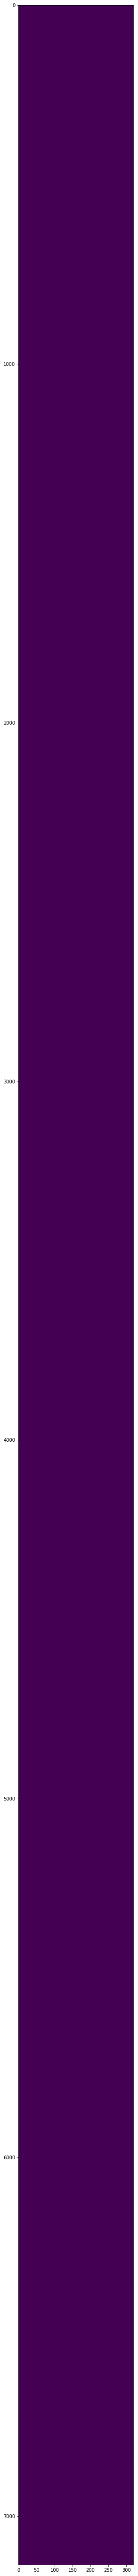

In [99]:
# plt.imshow(GeoDataset(img1_path).read_array())

In [ ]:
img1_fh.footprint.Intersection(img2_fh.footprint).GetEnvelope

In [ ]:
img1_fh.footprint.Intersection(img2_fh.footprint).GetEnvelope

In [91]:
cg = match(img1_cropped_path, img2_cropped_path)
cg.to_isis(os.path.splitext(cnet_path)[0])

AttributeError: 'NoneType' object has no attribute 'dtype'

In [20]:
# isis_files = get_path('isis_files')
# pass1_file = os.path.join(isis_files, 'pointreg_pass1.def')
# pass2_file = os.path.join(isis_files, 'pointreg_pass2.def')
# subpixel_registration(cubelis, cnet_path, [pass1_file, pass2_file])

In [27]:
import pandas as pd 
bundle_parameters = {
    'from_' : cubelis,
    'cnet' : cnet_path,
    'onet' : cnet_path,
    'radius' : 'yes',
    'update' : 'yes',
    'errorpropagation' : 'no',
    'outlier_rejection' : 'no',
    'sigma0' : '1.0e-10',
    'maxits' : 10,
    'camsolve' : 'accelerations',
    'twist' : 'yes',
    'overexisting' : 'yes',
    'spsolve' : 'no',
    'camera_angles_sigma' : .25,
    'camera_angular_velocity_sigma' : .1,
    'camera_angular_acceleration_sigma' : .01,
    'point_radius_sigma' : 50
}

try:
    jigsaw(**bundle_parameters)
except ProcessError as e:
    print('Jigsaw Error')
    print("STDOUT:", e.stdout.decode('utf-8'))
    print("STDERR:", e.stderr.decode('utf-8'))

df = pd.read_csv('residuals.csv', header=1)

residuals = df.iloc[1:]['residual.1'].astype(float)


Jigsaw Error
STDOUT: 
STDERR: **I/O ERROR** Invalid control network [/scratch/krodriguez/thm_matches/I01001001/I01001001/cnet.net].
**I/O ERROR** Reading the control network [cnet.net] failed.
**I/O ERROR** Failed to convert protobuf version 2 control point at index [0] into a ControlPoint.
**PROGRAMMER ERROR** The SerialNumber is not unique. A measure with serial number [Odyssey/THEMIS_IR/699921894.230] already exists for ControlPoint [0].



FileNotFoundError: File b'residuals.csv' does not exist